## Import Libraries

In [48]:
import gymnasium as gym
import gym_puddle
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3.dqn import MlpPolicy as DQNPolicy
from stable_baselines3.ppo import MlpPolicy as PPOPolicy

import time
import json

import matplotlib.pyplot as plt
import numpy as np

from IPython import display
import pyvirtualdisplay
import cv2

import libs.tiles3 as tc
import random


# ingore warning
import warnings
warnings.filterwarnings('ignore')


In [49]:
selected_seed = 0
np.random.seed(0)

## Visualization Functions

In [37]:

#some functions to help the visualization and interaction wit the environment

def visualize(frames, video_name = "/Video/video.mp4"):
    # Saves the frames as an mp4 video using cv2
    video_path = video_name
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(video_path, fourcc, 30, (width, height))
    for frame in frames:
        video_writer.write(frame)
    video_writer.release()

def online_rendering(image):
    #Visualize one frame of the image in a display
    ax.axis('off')
    img_with_frame = np.zeros((image.shape[0]+2, image.shape[1]+2, 3), dtype=np.uint8)
    img_with_frame[1:-1, 1:-1, :] = image
    ax.imshow(img_with_frame)
    display.display(plt.gcf())
    display.clear_output(wait=True)


def prepare_display():
  #Prepares display for onine rendering of the frames in the game
  _display = pyvirtualdisplay.Display(visible=False,size=(1400, 900))
  _ = _display.start()
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.axis('off')


def get_action():
    action = None
    while action not in ["w", "a", "s", "d", "W", "A", "S", "D"]:
        action = input("Enter action (w/a/s/d): ")
    if action == "w":
        return 3
    elif action == "a":
        return 0
    elif action == "s":
        return 2
    elif action == "d":
        return 1

## Accessing Different Environment Configurations

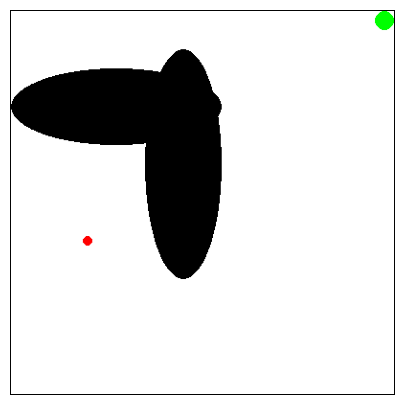

In [38]:
json_file = f"/Users/hadiaghazadeh/Library/CloudStorage/OneDrive-UniversityofCalgary/@upperboundCompetition/gym-puddle/gym_puddle/env_configs/pw1.json"

with open(json_file) as f:
  env_setup = json.load(f)


env = gym.make(
  "PuddleWorld-v0",
  start=env_setup["start"],
  goal=env_setup["goal"],
  goal_threshold=env_setup["goal_threshold"],
  noise=env_setup["noise"],
  thrust=env_setup["thrust"],
  puddle_top_left=env_setup["puddle_top_left"],
  puddle_width=env_setup["puddle_width"],
)


obs, info = env.reset()
image = env.render()
fig, ax = plt.subplots(figsize=(5, 5))

online_rendering(image)

## Environment Details

In [39]:
print("start position:", env.get_wrapper_attr("start"))
print("goal position:", env.get_wrapper_attr("goal"))
print("goal threshold:", env.get_wrapper_attr("goal_threshold"))
print("action noise:", env.get_wrapper_attr("noise"))
print("agent's thrust:", env.get_wrapper_attr("thrust"))
print("puddle top left positions:", env.get_wrapper_attr("puddle_top_left"))
print("puddle widths and heights:", env.get_wrapper_attr("puddle_width"))
print("action space:", env.get_wrapper_attr("actions"))
print("observation space:", env.get_wrapper_attr("observation_space"))

start position: [0.2 0.4]
goal position: [1. 1.]
goal threshold: 0.1
action noise: 0.01
agent's thrust: 0.05
puddle top left positions: [array([0.  , 0.85]), array([0.35, 0.9 ])]
puddle widths and heights: [array([0.55, 0.2 ]), array([0.2, 0.6])]
action space: [array([-0.05,  0.  ]), array([0.05, 0.  ]), array([ 0.  , -0.05]), array([0.  , 0.05])]
observation space: Box(0.0, 1.0, (2,), float64)


## Kanerva coding

In [45]:
from util.kanerva_ucb import BaseKanervaCoder
num_features = 700
n_closest = 7
rep = BaseKanervaCoder(env.observation_space, n_prototypes= num_features, n_closest= n_closest, seed= selected_seed)
rep.get_features_UBC(obs)

array([466, 465, 468, 467, 470, 464, 472])

## Q-learning

In [42]:
class tabularQlearning:
    def __init__(self, num_feature, num_actions, alpha=0.1, gamma=0.99, epsilon=0.1, seed = selected_seed):
        self.num_feature = num_feature
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-table with zeros
        self.q_table = np.zeros((self.num_feature, num_actions))

        self.seed = seed    
        # Set random seed
        np.random.seed(self.seed)

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy"""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            q = self.q_table[state].sum(axis=0)
            return q.argmax()
    
    def update(self, state, action, reward, next_state):
        """Update the Q-table using the Q-learning update rule"""
        self.q_table[state, action] += self.alpha * (reward + self.gamma * np.max(self.q_table[next_state]) - self.q_table[state, action])
    
    def get_q_table(self):
        return self.q_table

In [43]:
## simulare the agent in the environment
num_actions = len(env.get_wrapper_attr("actions"))
agent = tabularQlearning(num_feature= num_features, num_actions=num_actions)

num_episodes = 10000

for episode in range(num_episodes):
    obs, info = env.reset()
    state = rep.get_features_UBC(obs)
    done = False
    total_reward = 0
    while not done:
        action = agent.choose_action(state)
        next_obs, reward, done, trunc, _ = env.step(action)
        next_state = rep.get_features_UBC(next_obs)
        agent.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    if episode % 20 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")


Episode 0, Total Reward: -8629.625603117183
Episode 20, Total Reward: -81540.8951954049


KeyboardInterrupt: 

## Test the trained model

In [29]:

#Test the trained model
obs, info = env.reset()
total_reward = 0
episode_rewards = []
frames = []
observation = obs

max_video_length = 120


def greedy_policy(state):
    state_index = agent.encode_state(state)
    return np.argmax(agent.q_table[state_index])

for time_step in range(max_video_length):
    
    frames.append(env.render())

    #action = greedy_policy(get_features(observation))
    action = agent.choose_action(rep.get_features(observation))
    observation, reward, done, trunc, _ = env.step(action)
    total_reward += reward
    image = env.render()
    #online_rendering(image) #uncomment this line to see the online rendering of the environment frame by frame
    frames.append(image)

    print(f" t: {time_step}, observation: {observation}, reward: {reward}") #uncomment this line to see the environment-agent interaction details

    if done:
      print(f"total reward in this episode: {total_reward}")
      episode_rewards.append(total_reward)
      total_reward = 0
      break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "./Video/q_learning_Kan.mp4")

 t: 0, observation: [0.1907037  0.35549508], reward: -1
 t: 1, observation: [0.19181291 0.31102303], reward: -1
 t: 2, observation: [0.2507901  0.32485311], reward: -1
 t: 3, observation: [0.27157438 0.28510275], reward: -1
 t: 4, observation: [0.33879697 0.28520139], reward: -1
 t: 5, observation: [0.34851775 0.24364274], reward: -1
 t: 6, observation: [0.36682751 0.18932022], reward: -1
 t: 7, observation: [0.43761117 0.18776349], reward: -1
 t: 8, observation: [0.47977061 0.1952417 ], reward: -1
 t: 9, observation: [0.5384836 0.2152755], reward: -1
 t: 10, observation: [0.5927603 0.2266266], reward: -1
 t: 11, observation: [0.64278781 0.21707318], reward: -1
 t: 12, observation: [0.66101731 0.28126611], reward: -1
 t: 13, observation: [0.65496028 0.2364173 ], reward: -1
 t: 14, observation: [0.66386472 0.28334474], reward: -1
 t: 15, observation: [0.65711715 0.32951246], reward: -1
 t: 16, observation: [0.71031787 0.32400919], reward: -1
 t: 17, observation: [0.71803706 0.38640076],

## Q-Learning with Eligibility Trace

In [14]:
class tabularQlearningET:
    def __init__(self, num_feature, num_actions, alpha=0.1, gamma=0.99, epsilon=0.1, lambda_=0.9, seed = selected_seed):
        self.num_feature = num_feature
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambda_ = lambda_

        # Initialize Q-table with zeros
        self.q_table = np.zeros((self.num_feature, num_actions))
        self.eligibility = np.zeros(self.num_feature)

        self.seed = seed
        # Set random seed
        np.random.seed(self.seed)

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy"""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            q = self.q_table[state].sum(axis=0)
            return q.argmax()
    
    def update(self, state, action, reward, next_state):
        self.eligibility *= self.gamma * self.lambda_
        self.eligibility[state] =1

        v_next = self.gamma * self.q_table[next_state].sum(axis=0).max()

        td_error = reward + v_next - self.q_table[state, action].sum()

        alpha = self.alpha / len(state)

        self.q_table[:, action] += alpha * td_error * self.eligibility

    def erase_eligibility(self):
        self.eligibility = np.zeros(self.num_feature)
        
    def get_q_table(self):
        return self.q_table

In [17]:
## simulare the agent in the environment
num_actions = len(env.get_wrapper_attr("actions"))
agent = tabularQlearningET(num_feature= num_features, num_actions=num_actions)

num_episodes = 10000

for episode in range(num_episodes):
    obs, info = env.reset()
    state = rep.get_features(obs)
    done = False
    total_reward = 0
    agent.erase_eligibility()
    while not done:
        action = agent.choose_action(state)
        next_obs, reward, done, trunc, _ = env.step(action)
        next_state = rep.get_features(next_obs)
        agent.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    if episode % 20 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")


Episode 0, Total Reward: -2689.912530835113
Episode 20, Total Reward: -72
Episode 40, Total Reward: -44
Episode 60, Total Reward: -56
Episode 80, Total Reward: -64
Episode 100, Total Reward: -74
Episode 120, Total Reward: -66
Episode 140, Total Reward: -66
Episode 160, Total Reward: -376
Episode 180, Total Reward: -74
Episode 200, Total Reward: -52
Episode 220, Total Reward: -55
Episode 240, Total Reward: -48
Episode 260, Total Reward: -41
Episode 280, Total Reward: -44
Episode 300, Total Reward: -50
Episode 320, Total Reward: -278.1864330418383
Episode 340, Total Reward: -49
Episode 360, Total Reward: -54
Episode 380, Total Reward: -46
Episode 400, Total Reward: -44
Episode 420, Total Reward: -48
Episode 440, Total Reward: -50
Episode 460, Total Reward: -52
Episode 480, Total Reward: -47
Episode 500, Total Reward: -43
Episode 520, Total Reward: -44
Episode 540, Total Reward: -43
Episode 560, Total Reward: -48
Episode 580, Total Reward: -45
Episode 600, Total Reward: -42
Episode 620, T

In [21]:
obs, info = env.reset()
total_reward = 0
episode_rewards = []
frames = []
observation = obs

max_video_length = 120


for time_step in range(max_video_length):
    frames.append(env.render())

    #action = greedy_policy(get_features(observation))
    action = agent.choose_action(rep.get_features(observation))
    observation, reward, done, trunc, _ = env.step(action)
    total_reward += reward
    image = env.render()
    #online_rendering(image) #uncomment this line to see the online rendering of the environment frame by frame
    frames.append(image)

    print(f" t: {time_step}, observation: {observation}, reward: {reward}") #uncomment this line to see the environment-agent interaction details

    if done:
      print(f"total reward in this episode: {total_reward}")
      episode_rewards.append(total_reward)
      total_reward = 0
      break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "./Video/q_learning_Kan_ET.mp4")

 t: 0, observation: [0.20286288 0.34125826], reward: -1
 t: 1, observation: [0.24526551 0.33682478], reward: -1
 t: 2, observation: [0.24115111 0.28597662], reward: -1
 t: 3, observation: [0.24857013 0.24874332], reward: -1
 t: 4, observation: [0.24405617 0.20384785], reward: -1
 t: 5, observation: [0.249758   0.25979119], reward: -1
 t: 6, observation: [0.24375847 0.22434944], reward: -1
 t: 7, observation: [0.2451925  0.17720605], reward: -1
 t: 8, observation: [0.30637279 0.15724924], reward: -1
 t: 9, observation: [0.36446822 0.15213001], reward: -1
 t: 10, observation: [0.40841844 0.16233217], reward: -1
 t: 11, observation: [0.35921752 0.16504246], reward: -1
 t: 12, observation: [0.40835509 0.16760173], reward: -1
 t: 13, observation: [0.4116669  0.21085044], reward: -1
 t: 14, observation: [0.36832805 0.20767923], reward: -1
 t: 15, observation: [0.42826317 0.21118161], reward: -1
 t: 16, observation: [0.35851445 0.21728525], reward: -1
 t: 17, observation: [0.37766765 0.177604